# Step 1. 데이터 수집하기 + Step 2. 데이터 전처리하기

In [1]:
# 주요 라이브러리 버전 확인
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# TensorFlow 버전 출력
print(tf.__version__)

# 사용할 샘플의 최대 개수
MAX_SAMPLES = 10000
print("최대 샘플 수:", MAX_SAMPLES)

# 전처리 함수 정의
def preprocess_sentence(sentence):
    sentence = sentence.strip()  # 공백 제거
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 구두점 분리
    sentence = re.sub(r'[" "]+', " ", sentence)         # 연속된 공백을 하나로
    sentence = re.sub(r"[^가-힣0-9?.!,]+", " ", sentence)  # 한글, 숫자, 구두점 외의 문자는 공백으로 대체
    sentence = sentence.strip()
    return sentence

# 질문과 답변 데이터셋 로드 함수
def load_conversations(data_path):
    df = pd.read_csv(data_path)
    
    # 질문과 답변 리스트 생성
    inputs, outputs = [], []
    
    for idx, row in df.iterrows():
        if len(inputs) >= MAX_SAMPLES:
            break
        question, answer = row['Q'], row['A']
        inputs.append(preprocess_sentence(question))
        outputs.append(preprocess_sentence(answer))
    
    return inputs, outputs

# 데이터 경로 설정
data_path = os.path.expanduser("~/aiffel/transformer_chatbot/data/ChatbotData.csv")

# 데이터 로드
questions, answers = load_conversations(data_path)

# 데이터가 제대로 로드되었는지 확인
if questions is None or answers is None:
    print("데이터 로드에 실패했습니다.")
else:
    print('전체 샘플 수:', len(questions))
    print('전체 샘플 수:', len(answers))

    # 전처리 샘플 확인
    print('전처리 후의 20번째 질문 샘플: {}'.format(questions[19]))
    print('전처리 후의 20번째 답변 샘플: {}'.format(answers[19]))


Matplotlib is building the font cache; this may take a moment.


2.6.0
최대 샘플 수: 10000
전체 샘플 수: 10000
전체 샘플 수: 10000
전처리 후의 20번째 질문 샘플: 가스비 너무 많이 나왔다 .
전처리 후의 20번째 답변 샘플: 다음 달에는 더 절약해봐요 .


# Step 3. SubwordTextEncoder 사용하기

In [2]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [3]:
# 시작 토큰과 종료 토큰에 고유한 정수 부여하기
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 단어장 크기 (시작, 종료 토큰 포함)
VOCAB_SIZE = tokenizer.vocab_size + 2

print('START_TOKEN의 번호 :', START_TOKEN)
print('END_TOKEN의 번호 :', END_TOKEN)
print('단어장 크기 :', VOCAB_SIZE)

START_TOKEN의 번호 : [8856]
END_TOKEN의 번호 : [8857]
단어장 크기 : 8858


In [4]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업 수행
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [8546, 3652, 7139]
정수 인코딩 후의 21번째 답변 샘플: [1761, 5697, 7, 4735, 115, 1]


In [5]:
# 샘플의 최대 허용 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [6]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 시작과 종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 조건에 맞는 데이터만 저장
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 패딩 적용
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')

    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [7]:
# 데이터셋 필터링 및 패딩 적용
questions, answers = tokenize_and_filter(questions, answers)

print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수:', len(questions))
print('필터링 후의 답변 샘플 개수:', len(answers))

단어장의 크기 : 8858
필터링 후의 질문 샘플 개수: 10000
필터링 후의 답변 샘플 개수: 10000


In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

# tf.data.Dataset으로 변환
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더 입력
    },
    {
        'outputs': answers[:, 1:]     # 디코더 출력 (레이블)
    },
))

# 셔플 및 배치 적용
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


In [9]:
# 임의의 샘플 확인 (예: 15번째 샘플로 변경)
sample_index = 15  # 원하는 샘플 인덱스로 변경
print(f'정수 인코딩된 {sample_index + 1}번째 질문 샘플:', questions[sample_index])
print(f'정수 인코딩된 {sample_index + 1}번째 답변 샘플:', answers[sample_index])

# 정수 인코딩된 샘플을 다시 디코딩하여 확인
print(f'{sample_index + 1}번째 디코딩된 질문:', tokenizer.decode([i for i in questions[sample_index] if i not in [0, START_TOKEN[0], END_TOKEN[0]]]))  # START_TOKEN과 END_TOKEN을 제외한 토큰만 디코딩
print(f'{sample_index + 1}번째 디코딩된 답변:', tokenizer.decode([i for i in answers[sample_index] if i not in [0, START_TOKEN[0], END_TOKEN[0]]]))


정수 인코딩된 16번째 질문 샘플: [8856   77   70 1196 4075 2279 8857    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
정수 인코딩된 16번째 답변 샘플: [8856 5614 7204  102    1 8857    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
16번째 디코딩된 질문: 가만 있어도 땀난다
16번째 디코딩된 답변: 땀을 식혀주세요 .


# Step 4. 모델 구성하기

In [10]:
import tensorflow as tf

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position 
        self.d_model = d_model 
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        # 각 위치에 대한 각도를 계산
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cos 값을 하나의 배열로 병합
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        # HDF5 직렬화를 위한 설정 반환
        config = super(PositionalEncoding, self).get_config()
        config.update({
            "position": self.position,
            "d_model": self.d_model
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [11]:
def scaled_dot_product_attention(query, key, value, mask):
  # Q와 K의 내적
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화 (스케일링)
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax로 가중치 계산
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 가중치를 V에 적용
  output = tf.matmul(attention_weights, value)
  return output

In [12]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        # 멀티 헤드로 분리
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만들기
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후 각 결과를 다시 연결(concatenate)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용
        outputs = self.dense(concat_attention)
        return outputs

    def get_config(self):
        # HDF5 직렬화를 위한 설정 반환
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [13]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [14]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [15]:
# 인코더 하나의 레이어를 함수로 구현
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [16]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [17]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉 수행
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [18]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [19]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용
  # 내부에 패딩 마스크도 포함
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [20]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3321856     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [21]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3321856     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [22]:
# 손실 함수(Loss function)
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

# Step 5. 모델 평가하기

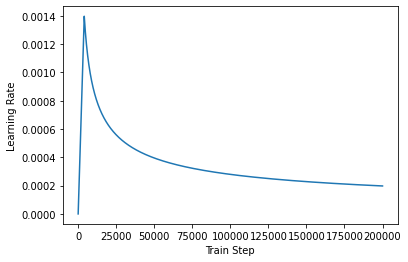

In [23]:
# 커스텀 된 학습률(Learning rate)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, **kwargs):
        super(CustomSchedule, self).__init__(**kwargs)
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):  # get_config() 추가 (직렬화 가능하게)
        return {"d_model": int(self.d_model.numpy()), "warmup_steps": self.warmup_steps}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# 학습률 스케줄링 확인
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [24]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [25]:
# 훈련하기
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
157/157 [==============================] - 27s 54ms/step - loss: 1.4194 - accuracy: 0.0210
Epoch 2/30
157/157 [==============================] - 8s 54ms/step - loss: 1.1844 - accuracy: 0.0490
Epoch 3/30
157/157 [==============================] - 9s 54ms/step - loss: 0.9935 - accuracy: 0.0498
Epoch 4/30
157/157 [==============================] - 9s 54ms/step - loss: 0.9030 - accuracy: 0.0519
Epoch 5/30
157/157 [==============================] - 9s 54ms/step - loss: 0.8481 - accuracy: 0.0549
Epoch 6/30
157/157 [==============================] - 9s 54ms/step - loss: 0.7970 - accuracy: 0.0578
Epoch 7/30
157/157 [==============================] - 9s 55ms/step - loss: 0.7425 - accuracy: 0.0622
Epoch 8/30
157/157 [==============================] - 9s 55ms/step - loss: 0.6835 - accuracy: 0.0680
Epoch 9/30
157/157 [==============================] - 9s 55ms/step - loss: 0.6177 - accuracy: 0.0756
Epoch 10/30
157/157 [==============================] - 9s 55ms/step - loss: 0.5457 - accur

In [26]:
import os
import pickle
import tensorflow as tf

# 저장 경로 (HDF5 포맷)
model_save_path = os.path.expanduser("~/aiffel/transformer_chatbot/model/model.h5")

# 모델 저장 (HDF5 포맷)
model.save(model_save_path)
print(f" 모델 저장 완료: {model_save_path}")

# 토크나이저 저장
tokenizer_save_path = os.path.expanduser("~/aiffel/transformer_chatbot/model/tokenizer.pickle")
with open(tokenizer_save_path, "wb") as f:
    pickle.dump(tokenizer, f)
print(f" 토크나이저 저장 완료: {tokenizer_save_path}")

 모델 저장 완료: /aiffel/aiffel/transformer_chatbot/model/model.h5
 토크나이저 저장 완료: /aiffel/aiffel/transformer_chatbot/model/tokenizer.pickle


In [27]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측 반복
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가
    # 이 output_sequence는 다시 디코더의 입력이 됨
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [28]:
# 임의의 입력 문장에 대해 챗봇의 대답을 얻는 sentence_generation() 함수
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받음
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [29]:
import os
import pickle
import tensorflow as tf

#  모델과 토크나이저 저장 경로
model_load_path = os.path.expanduser("~/aiffel/transformer_chatbot/model/model.h5")
tokenizer_load_path = os.path.expanduser("~/aiffel/transformer_chatbot/model/tokenizer.pickle")

#  HDF5 포맷 모델 불러오기
try:
    model = tf.keras.models.load_model(
        model_load_path,
        custom_objects={
            "PositionalEncoding": PositionalEncoding,
            "MultiHeadAttention": MultiHeadAttention,
            "CustomSchedule": CustomSchedule
        },
        compile=False
    )
    print(f"모델 로드 완료: {model_load_path}")
except Exception as e:
    print(f" 모델 로드 실패: {e}")

#  토크나이저 불러오기
try:
    with open(tokenizer_load_path, "rb") as f:
        tokenizer = pickle.load(f)
    print(f" 토크나이저 로드 완료: {tokenizer_load_path}")
except Exception as e:
    print(f" 토크나이저 로드 실패: {e}")

print(" 모델, 토크나이저 로드 완료.")

# 챗봇 파라미터 설정
START_TOKEN = [tokenizer.vocab_size]
END_TOKEN = [tokenizer.vocab_size + 1]
MAX_LENGTH = 40  # 최대 문장 길이

def preprocess_sentence(sentence):
    """입력 문장을 전처리하는 함수"""
    return sentence.strip()

def decoder_inference(sentence):
    """입력 문장에 대한 챗봇 응답을 생성하는 함수"""
    sentence = preprocess_sentence(sentence)

    # 문장을 토크나이저로 인코딩 후 시작/종료 토큰 추가
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for _ in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predicted_id = tf.cast(tf.argmax(predictions[:, -1:, :], axis=-1), tf.int32)

        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    predicted_sentence = tokenizer.decode(
        [i for i in tf.squeeze(output_sequence) if i < tokenizer.vocab_size]
    )
    return predicted_sentence

def chatbot():
    """실제 챗봇을 실행하는 함수"""
    print(" 챗봇을 시작합니다. '종료'라고 입력하면 대화가 종료됩니다.")

    while True:
        user_input = input("유저: ")

        if user_input.strip().lower() == "종료":
            print(" 챗봇을 종료합니다. ")
            break

        response = decoder_inference(user_input)
        print(f" 챗봇: {response}")

# 챗봇 실행
if __name__ == "__main__":
    chatbot()

모델 로드 완료: /aiffel/aiffel/transformer_chatbot/model/model.h5
 토크나이저 로드 완료: /aiffel/aiffel/transformer_chatbot/model/tokenizer.pickle
 모델, 토크나이저 로드 완료.
 챗봇을 시작합니다. '종료'라고 입력하면 대화가 종료됩니다.
유저: 안녕하세요?
 챗봇: 천천히 생각해보세요 .
유저: 배고픈데 메뉴 추천 해줘
 챗봇: 뭐라도 드세요 .
유저: 뭐 먹을까?
 챗봇: 많이 배우면 좋죠 .
유저: 추워
 챗봇: 따듯한 차 한잔 어때요 ?
유저: 날씨 어때?
 챗봇: 천천히 생각해보세요 .
유저: 졸려
 챗봇: 오늘 일찍 주무세요 .
유저: 오 대화가 되는 것 같기도 하고
 챗봇: 운명일지도 모르겠어요 .
유저: ㅋㅋㅋㅋㅋㅋㅋㅋ
 챗봇: 스트레스 받으시는 일 있으신거죠 .
유저: 아니야
 챗봇: 힘내세요 !
유저: 알았어 안녕!
 챗봇: 이젠 그분을 놓아줄 때가 되었나봐요 .
유저: 종료
 챗봇을 종료합니다. 


심심이 같은 느낌...